In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import trades, plots, params, models, feats
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)
importlib.reload(feats)

<module 'libs.feats' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/feats.py'>

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)

import matplotlib.pyplot as plt
import seaborn as sns

import glob
import os
import json

import time
import datetime as dt
from tqdm.auto import tqdm
from IPython.display import clear_output, display

In [3]:
# df_sign = pd.read_csv(
#     params.sign_csv, index_col=0, parse_dates=True
# )

# frames = []
# print("Generating all indicators features (standard, engineered, custom) …")
# for day, day_df in tqdm(
#     df_sign.groupby(df_sign.index.normalize()),
#     desc="Days", unit="day"
# ):
#     # 1) Standard textbook indicators
#     std_feats = feats.create_standard_features(day_df)

#     # 2) Engineered signals _directly_ on standard indicators
#     eng_feats = feats.features_engineering(
#         std_feats
#     )

#     # 3) Custom-window indicators aligned to smooth_sign_win_tick
#     cust_feats = feats.create_custom_window_features(
#         day_df,
#         base_w=False # params.smooth_sign_win_tick
#     )

#     # 4) Merge all three sets and drop any rows with NaNs
#     feats_main = pd.concat([std_feats, eng_feats, cust_feats], axis=1).dropna()
#     frames.append(feats_main)

# # Final concatenation across days
# df_feat = pd.concat(frames).sort_index()
# df_feat


# 1) Read sign timestamps (with pre-market included)
df_sign = pd.read_csv(
    params.sign_csv, index_col=0, parse_dates=True
)

frames = []
print("Generating all indicator features (raw + custom + engineered) …")

for day, day_df in tqdm(
    df_sign.groupby(df_sign.index.normalize()),
    desc="Days", unit="day"
):
    # 2) Compute raw standard + custom-window features in one call
    day_feats = feats.create_features(
        day_df,
        sma_short   = 20,
        sma_long    = 100,
        rsi_window  = 14,
        macd_fast   = 12,
        macd_slow   = 26,
        macd_sig    = 9,
        atr_window  = 14,
        bb_window   = 20,
        obv_sma     = 14,
        vwap_window = 20,
        base_w      = params.smooth_sign_win_tick  # or None/False to skip custom
    )

    # 3) Build stationary, ratio-based eng_* signals
    eng_feats = feats.features_engineering(day_feats)

    # 4) Merge raw/custom + engineered, drop any NaNs
    feats_main = pd.concat([day_feats, eng_feats], axis=1).dropna()

    frames.append(feats_main)

# 5) Glue back into one long DataFrame
df_feat = pd.concat(frames).sort_index()
df_feat

Generating all indicator features (raw + custom + engineered) …


Days:   0%|          | 0/5400 [00:00<?, ?day/s]

,open,high,low,close,volume,bid,ask,signal,rsi_14,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,sma_20,sma_100,atr_14,bb_lband_20,bb_hband_20,bb_width_20,plus_di_14,minus_di_14,adx_14,obv,obv_sma_14,vwap_20,vol_spike_14,vwap_dev_20,hour,day_of_week,month,ema_7,sma_7,sma_15,sma_30,macd_diff_7_15_3,atr_15,atr_30,bb_lband_15,bb_hband_15,bb_width_15,rsi_15,stoch_k_15,stoch_d_3,plus_di_15,minus_di_15,adx_15,obv_sma_15,vwap_dev_15,vol_spike_15,r_1,r_15,r_30,vol_15,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div
2004-01-02 13:09:00,0.764235,0.764235,0.764235,0.764235,48081.25,0.763664,0.764807,0.021536,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,19.934,6791837.50,6789218.750,0.764278,1.558,-0.000056,13,4,1,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,18.696,6777137.500,-0.000053,1.567,-0.000022,-0.000066,-0.000066,0.000009,0.000,-0.0,23549.107,0.3,-0.000,0.000,0.0
2004-01-02 13:10:00,0.764219,0.764219,0.764219,0.764219,54775.00,0.763647,0.764790,0.023284,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,25.653,6737062.50,6796437.500,0.764273,1.671,-0.000071,13,4,1,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,24.117,6785741.667,-0.000066,1.687,-0.000022,-0.000088,-0.000088,0.000010,0.000,-0.0,21875.000,0.3,-0.057,-0.009,0.0
2004-01-02 13:11:00,0.764202,0.764202,0.764202,0.764202,61468.75,0.763631,0.764773,0.025175,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,30.964,6675593.75,6797265.625,0.764266,1.748,-0.000084,13,4,1,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,29.175,6788381.250,-0.000076,1.772,-0.000022,-0.000110,-0.000110,0.000011,0.000,-0.0,20200.893,0.3,-0.110,-0.018,0.0
2004-01-02 13:12:00,0.764185,0.764185,0.764185,0.764185,68162.50,0.763614,0.764757,0.027222,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,35.895,6607431.25,6791225.000,0.764257,1.792,-0.000094,13,4,1,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,33.897,6784610.000,-0.000085,1.824,-0.000022,-0.000131,-0.000131,0.000011,0.000,-0.0,18526.786,0.3,-0.159,-0.027,0.0
2004-01-02 13:13:00,0.764169,0.764169,0.764169,0.764169,74856.25,0.763597,0.764740,0.029436,0.000,-0.000,-0.000,-0.000,0.764,0.764,0.000,0.764,0.764,0.000,0.000,100.000,40.474,6532575.00,6777837.500,0.764247,1.809,-0.000103,13,4,1,0.764,0.764,0.764,0.764,-0.000,0.000,0.000,0.764,0.764,0.000,0.000,0.000,0.000,0.000,100.000,38.304,6773981.667,-0.000091,1.849,-0.000022,-0.000153,-0.000153,0.000011,0.000,-0.0,16852.679,0.3,-0.205,-0.036,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,196.680000,196.860000,196.630000,196.815000,385695.00,196.667400,196.962600,0.684908,67.217,0.176,0.135,0.041,196.326,195.931,0.251,195.927,196.725,0.004,36.312,7.485,30.194,4282659.00,3253867.571,196.467694,1.641,0.001768,20,2,6,196.567,196.547,196.366,196.181,0.020,0.247,0.219,195.940,196.792,0.004,66.709,73.661,62.549,35.895,7.958,28.287,3226657.000,0.001548,1.703,0.000635,0.003639,0.004048,0.000804,0.001,0.0,22.500,0.0,0.029,0.316,3.0
2025-06-18 20:57:00,196.810000,196.940000,196.560000,196.675000,460630.00,196.527500,196.822500,0.612206,61.669,0.179,0.144,0.036,196.349,195.937,0.260,195.925,196.772,0.004,34.721,6.704,32.868,3822029.00,3316982.500,196.502663,1.763,0.000877,20,2,6,196.594,196.557,196.406,196.210,0.007,0.256,0.225,195.986,196.827,0.004,61.512,58.962,65.041,34.426,7.170,30.770,3291745.000,0.000637,1.842,-0.000712,0.003081,0.004384,0.000836,0.001,0.0,0.000,0.0,0.036,0.152,3.1
2025-06-18 20:58:00,196.675000,196.740000,196.630000,196.670000,525245.00,196.522500,196.817500,0.

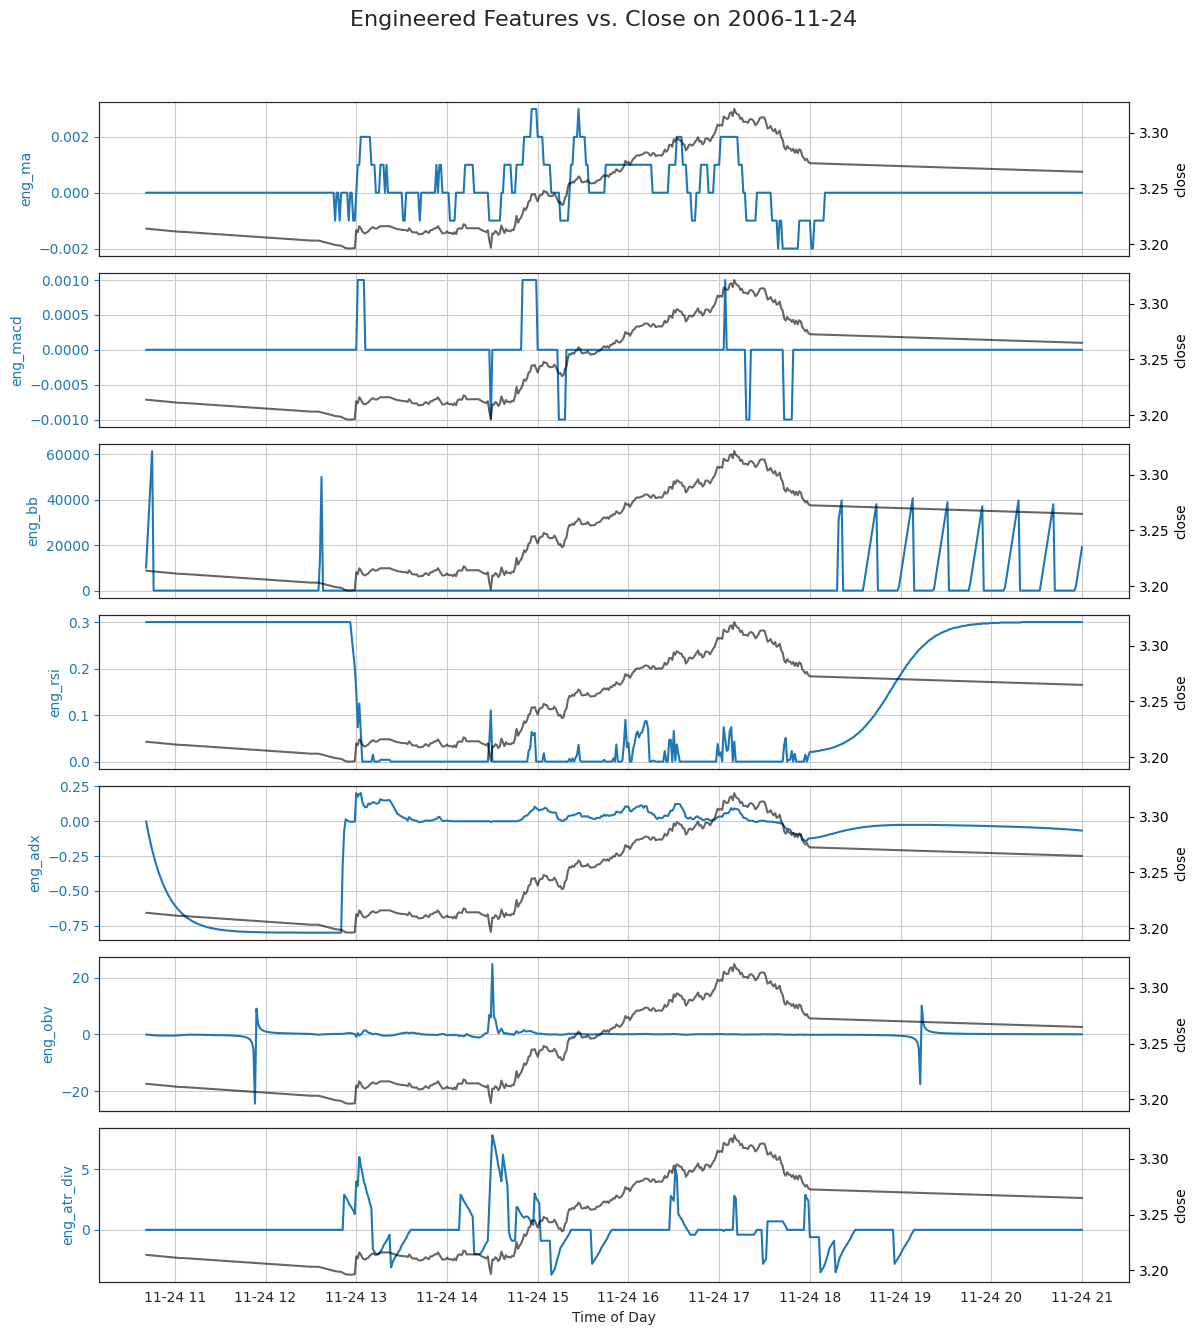

In [4]:
# 1) Identify engineered‐feature columns and the raw close price column
eng_features = [c for c in df_feat.columns if c.startswith("eng_")]
close_col    = "close"

# 2) Pick a random trading day and convert to pandas Timestamp
all_days   = df_feat.index.normalize().unique()
random_day = np.random.choice(all_days)
day_ts     = pd.to_datetime(random_day)

# 3) Subset the DataFrame to that single day
mask         = df_feat.index.normalize() == random_day
df_day_feats = df_feat.loc[mask, eng_features]
df_day_close = df_feat.loc[mask, close_col]

# 4) Create one subplot per engineered feature
fig, axes = plt.subplots(
    nrows   = len(eng_features),
    ncols   = 1,
    figsize = (12, 2 * len(eng_features)),
    sharex  = True
)
fig.suptitle(f"Engineered Features vs. Close on {day_ts.date()}", fontsize=16)

# 5) Plot each feature on its own left‐y axis, and close price on a right‐y axis
for ax, feat in zip(axes, eng_features):
    # left axis: engineered feature
    ax.plot(df_day_feats.index, df_day_feats[feat],
            color="C0", label=feat)
    ax.set_ylabel(feat, color="C0")
    ax.tick_params(axis="y", colors="C0")
    ax.grid(True)

    # right axis: raw close price
    ax2 = ax.twinx()
    ax2.plot(df_day_close.index, df_day_close,
             color="k", alpha=0.6, label="close")
    ax2.set_ylabel("close", color="k")
    ax2.tick_params(axis="y", colors="k")

# 6) Final formatting
axes[-1].set_xlabel("Time of Day")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


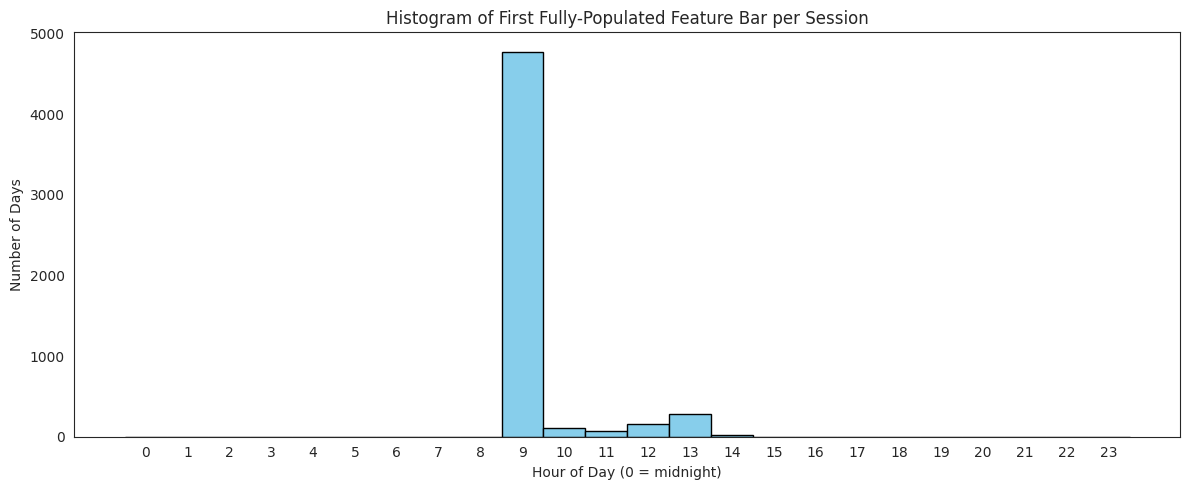

In [5]:
# -----------------------------------------------------------------------------
# What this plot shows:
#   We measure, for each trading day, the first 1-minute bar when *every* feature has a non-null value.  
#   Plotting the histogram of those hours tells how long the indicators take to “warm up” each morning before the model can run.
# -----------------------------------------------------------------------------

# 1) Prepare a DataFrame without bid/ask (and any non-feature cols)
df_feat_unsc = df_feat.drop(columns=["bid", "ask"], errors="ignore")

# 2) Identify all feature columns (those starting with "feat_")
feat_cols = [c for c in df_feat_unsc.columns if c != 'signal']

# 3) For each calendar day, find the first timestamp where *all* feat_ cols are non-null
first_valid = (
    df_feat_unsc
      .groupby(df_feat_unsc.index.normalize())
      .apply(lambda grp: grp.dropna(subset=feat_cols).index.min())
)

# 4) Extract the hour (0–23) of that first fully-populated bar
first_valid_hours = first_valid.dt.hour

# 5) Plot the histogram
plt.figure(figsize=(12, 5))
plt.hist(
    first_valid_hours,
    bins=range(0, 25),       # 24 one-hour bins
    align='left',
    color='skyblue',
    edgecolor='black'
)
plt.xticks(range(0, 24))
plt.xlabel('Hour of Day (0 = midnight)')
plt.ylabel('Number of Days')
plt.title('Histogram of First Fully-Populated Feature Bar per Session')
plt.tight_layout()
plt.show()


In [11]:
importlib.reload(feats) ###################

# Scaling all features indicators

df_feat_all = feats.scale_with_splits(
    df           = df_feat,
    train_prop   = params.train_prop,
    val_prop     = params.val_prop
)

df_feat_all

train days:   0%|          | 0/3833 [00:00<?, ?day/s]

val days:   0%|          | 0/785 [00:00<?, ?day/s]

test days:   0%|          | 0/784 [00:00<?, ?day/s]

,rsi_14,macd_line_12_26_9,macd_signal_12_26_9,macd_diff_12_26_9,sma_20,sma_100,atr_14,bb_lband_20,bb_hband_20,bb_width_20,plus_di_14,minus_di_14,adx_14,obv,obv_sma_14,vwap_20,vol_spike_14,vwap_dev_20,ema_7,sma_7,sma_15,sma_30,macd_diff_7_15_3,atr_15,atr_30,bb_lband_15,bb_hband_15,bb_width_15,rsi_15,stoch_k_15,stoch_d_3,plus_di_15,minus_di_15,adx_15,obv_sma_15,vwap_dev_15,vol_spike_15,r_1,r_15,r_30,vol_15,eng_ma,eng_macd,eng_bb,eng_rsi,eng_adx,eng_obv,eng_atr_div,open,high,low,close,volume,bid,ask,signal,hour,day_of_week,month
2004-01-02 13:09:00,0.00000,0.00000,1.00000,0.19934,0.00000,0.00000,0.00000,0.00000,1.00000,0.18696,0.111549,0.642061,0.625459,0.104721,0.474260,0.515377,0.528843,0.500000,0.6,0.018115,1.0,0.500000,0.666667,0.315907,0.509338,0.467641,0.484536,0.000087,0.000052,0.000000,0.000139,0.000052,0.000000,0.322382,0.322619,0.000094,0.000104,0.000122,0.000104,0.000087,0.517986,0.000000,0.000000,0.000156,0.000069,0.000000,0.322633,0.000279,0.764235,0.764235,0.764235,0.764235,48081.25,0.763664,0.764807,0.021536,0.496,-0.976,0.696
2004-01-02 13:10:00,0.00000,0.00000,1.00000,0.25653,0.00000,0.00000,0.00000,0.00000,1.00000,0.24117,0.119645,0.641972,0.625379,0.112746,0.474260,0.515304,0.528775,0.500000,0.6,0.016827,1.0,0.464375,0.666667,0.315907,0.509338,0.467641,0.484536,0.000087,0.000052,0.000000,0.000139,0.000052,0.000000,0.322367,0.322621,0.000093,0.000104,0.000122,0.000104,0.000087,0.517986,0.000000,0.000000,0.000156,0.000069,0.000000,0.322635,0.000310,0.764219,0.764219,0.764219,0.764219,54775.00,0.763647,0.764790,0.023284,0.496,-0.976,0.696
2004-01-02 13:11:00,0.00000,0.00000,1.00000,0.30964,0.00000,0.00000,0.00000,0.00000,1.00000,0.29175,0.125161,0.641894,0.625318,0.118430,0.474260,0.515231,0.528707,0.500000,0.6,0.015539,1.0,0.431250,0.666667,0.315907,0.509338,0.467641,0.484536,0.000087,0.000052,0.000000,0.000139,0.000052,0.000000,0.322351,0.322621,0.000093,0.000104,0.000122,0.000104,0.000087,0.517986,0.000000,0.000000,0.000156,0.000069,0.000000,0.322636,0.000341,0.764202,0.764202,0.764202,0.764202,61468.75,0.763631,0.764773,0.025175,0.496,-0.976,0.696
2004-01-02 13:12:00,0.00000,0.00000,1.00000,0.35895,0.00000,0.00000,0.00000,0.00000,1.00000,0.33897,0.128314,0.641835,0.625263,0.121907,0.474260,0.515161,0.528641,0.500000,0.6,0.014251,1.0,0.400625,0.666667,0.315907,0.509338,0.467641,0.484536,0.000087,0.000052,0.000000,0.000139,0.000052,0.000000,0.322334,0.322619,0.000093,0.000104,0.000122,0.000104,0.000087,0.517986,0.000000,0.000000,0.000156,0.000069,0.000000,0.322635,0.000341,0.764185,0.764185,0.764185,0.764185,68162.50,0.763614,0.764757,0.027222,0.496,-0.976,0.696
2004-01-02 13:13:00,0.00000,0.00000,1.00000,0.40474,0.00000,0.00000,0.00000,0.00000,1.00000,0.38304,0.129531,0.641781,0.625227,0.123579,0.474260,0.515088,0.528573,0.500000,0.6,0.012964,1.0,0.371875,0.666667,0.315907,0.509338,0.467641,0.484536,0.000087,0.000052,0.000000,0.000139,0.000052,0.000000,0.322314,0.322616,0.000093,0.000104,0.000122,0.000104,0.000087,0.517986,0.000000,0.000000,0.000156,0.000069,0.000000,0.322632,0.000341,0.764169,0.764169,0.764169,0.764169,74856.25,0.763597,0.764740,0.029436,0.496,-0.976,0.696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.67217,0.36312,0.07485,0.30194,0.66709,0.73661,0.62549,0.35895,0.07958,0.28287,0.117495,0.652911,0.635234,0.113816,0.478595,0.527683,0.541606,0.515625,0.6,0.000017,0.0,0.518125,0.666667,0.327030,0.808149,0.749478,0.625430,3.399805,3.398280,0.534043,3.397055,3.399910,0.024691,0.321726,0.321693,3.402269,3.403066,3.402026,3.399395,3.398880,0.661871,0.480545,0.270370,3.393991,3.401916,0.023121,0.321703,0.024910,196.680000,196.860000,196.630000,196.815000,385695.00,196.667400,196.962600,0.684908,-0.976,0.039,-0.861
2025-06-18 20:57:00,0.61669,0.34721,0.06704,0.32868,0.61512,0.58962,0.65041,

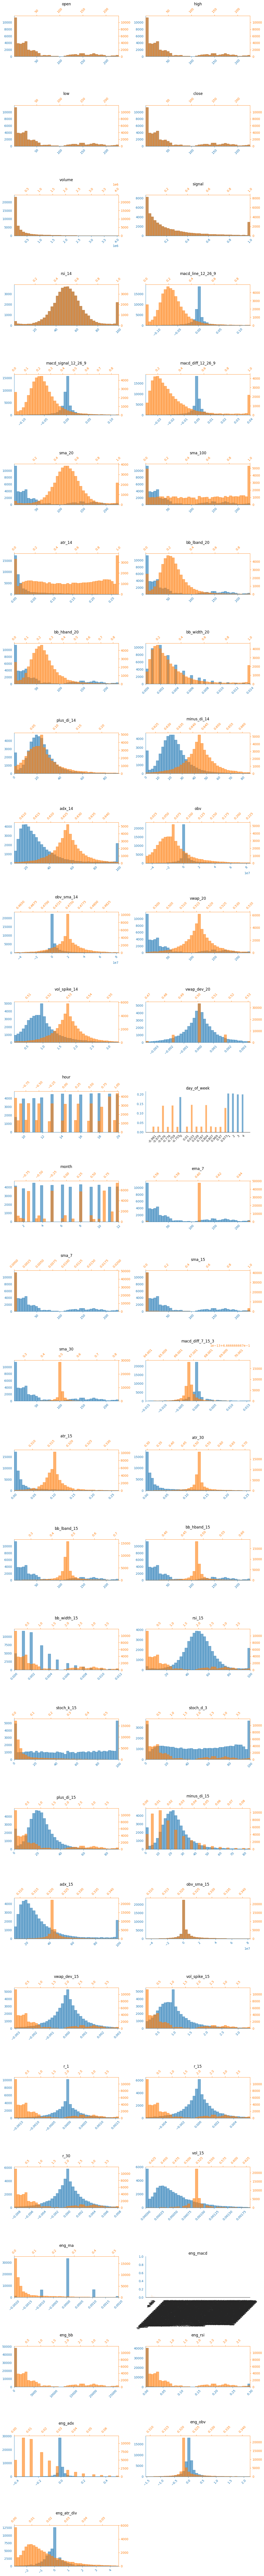

In [12]:
df_feat_scal = df_feat_all.drop(['bid','ask'], axis=1)

plots.plot_dual_histograms(
    df_before = df_feat_unsc,
    df_after  = df_feat_scal,
)

In [13]:
print("saving df …")
df_feat_all.to_csv(params.feat_all_csv) # saving also bid and ask
print("saved df")

saving df …
saved df
